In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

## Откройте и изучите файл

In [3]:
data = pd.read_csv('/content/drive/My Drive/Collab file/users_behavior.csv')

In [4]:
# функция для распаковки данных

def open_data(data):
  display(data.head())
  print('------------------------')
  print('Общая информация')
  data.info()
  print('------------------------')
  print('Описание данных')
  display(data.describe())
  print('------------------------')
  print('Количество дубликатов')
  print(data.duplicated().sum())
  print('------------------------')
  print('Количество пропусков')
  display(data.isna().sum())

In [5]:
open_data(data)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
------------------------
Описание данных


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


------------------------
Количество дубликатов
0
------------------------
Количество пропусков


calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

**Комментарий:**
<br> Данные выгружены успешно, предобработка не требуется.

## Разбейте данные на выборки

In [6]:
#поделим наши данные в начале на тренировочную и валидационную выборки

data_train, data_valid = train_test_split(
    data, test_size=0.4, random_state=12345)

In [7]:
#теперь из валидационной выборки отделим данные для тестовой, данные разбиты в соотношении 3:1:1

data_valid, data_test = train_test_split(
    data_valid, test_size=0.5, random_state=12345)

In [8]:
#создаем переменные для признаков и целевого признака

features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

In [9]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(1928, 5)
(643, 5)
(643, 5)


## Исследуйте модели

In [10]:
# для наглядности результатов сведем полученные метрики в таблицу

def metrics(result_valid, model, data):
    data.loc[model, 'Accuracy_valid'] = result_valid
    
    return data

In [11]:
# таблица для сравнения результатов работы моделей

compare_models = pd.DataFrame(columns=['Accuracy_valid'])

### Создание baseline модели

In [12]:
%%time

dummy = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_model = dummy.fit(features_train, target_train)

dummy_pred_train = dummy_model.predict(features_train)
dummy_pred_valid = dummy_model.predict(features_valid)
dummy_pred_test = dummy_model.predict(features_test)

dummy_acc_train = accuracy_score(target_train, dummy_pred_train)
dummy_acc_valid = accuracy_score(target_valid, dummy_pred_valid)
dummy_acc_test = accuracy_score(target_test, dummy_pred_test)

print('Accuracy для константной модели на обучающей выборке:{:.2f}'.format(dummy_acc_train))
print('Accuracy для константной модели на валидационной выборке:{:.2f}'.format(dummy_acc_valid))
print('Accuracy для константной модели на тестовой выборке:{:.2f}'.format(dummy_acc_test))

Accuracy для константной модели на обучающей выборке:0.69
Accuracy для константной модели на валидационной выборке:0.71
Accuracy для константной модели на тестовой выборке:0.68
CPU times: user 9.74 ms, sys: 0 ns, total: 9.74 ms
Wall time: 12.2 ms


In [13]:
metrics(dummy_acc_valid, 'Baseline model', compare_models)

,Accuracy_valid
Baseline model,0.706065


### Случайный лес

In [14]:
%%time 

# подберем наилучшие параметры для модели случайного леса

best_features = 0
best_criterion = None
best_depth = 0
best_model_r = None
best_result_r = 0
best_est = 0

for crit in tqdm(['gini', 'entropy']):
    for max_features in ['sqrt', 'log2']:
        for est in range(7,35):
            for depth in range(5,25):
                model_r = RandomForestClassifier(random_state=45, criterion=crit,
                                    max_features=max_features, max_depth=depth, n_estimators=est)
                model_r.fit(features_train, target_train)
                predictions = model_r.predict(features_valid)
                result = model_r.score(features_valid, target_valid)
                if result > best_result_r:
                    best_criterion = crit
                    best_features = max_features
                    best_depth = depth
                    best_model_r = model_r
                    best_result_r = result
                    best_est = est

print('Accuracy наилучшей модели на валидационной выборке:', best_result_r)
print('Количество деревьев:', best_est)
print('Глубина:', best_depth)
print('Число признаков:', best_features)
print('Критерий расщепления:', best_criterion)

100%|██████████| 2/2 [04:05<00:00, 122.91s/it]

Accuracy наилучшей модели на валидационной выборке: 0.8102643856920684
Количество деревьев: 14
Глубина: 9
Число признаков: sqrt
Критерий расщепления: entropy
CPU times: user 4min 3s, sys: 708 ms, total: 4min 4s
Wall time: 4min 5s


In [15]:
# посмотрим на важность признаков для модели

fi = pd.DataFrame({'feature': list(features_train.columns),
                   'importance': best_model_r.feature_importances_}).\
                    sort_values('importance', ascending = False)

display(fi)

,feature,importance
3,mb_used,0.379926
1,minutes,0.247990
2,messages,0.197699
0,calls,0.174385


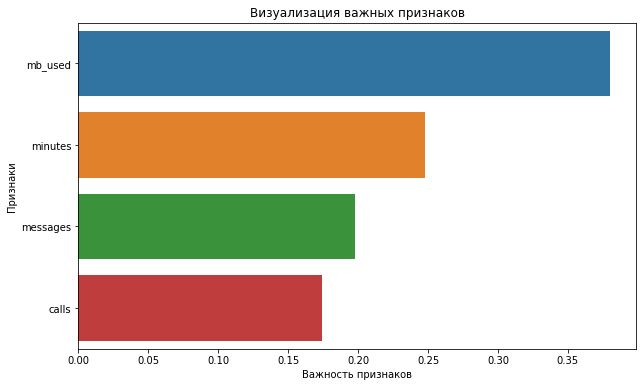

In [16]:
plt.figure(figsize=(10,6))

sns.barplot(x=fi['importance'], y=fi['feature'])

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

In [17]:
metrics(best_result_r, 'RF Classifier', compare_models)

,Accuracy_valid
Baseline model,0.706065
RF Classifier,0.810264


### Дерево решений

In [18]:
%%time 

# подберем наилучшие параметры для модели дерева решений

best_features = 0
best_criterion = None
best_depth = 0
best_model_d = None
best_result_d = 0

for crit in tqdm(['gini', 'entropy']):
    for max_features in ['sqrt', 'log2']:
        for depth in range(5,25):
             model_d = DecisionTreeClassifier(random_state=4545, criterion=crit,
                                     max_depth=depth)
             model_d.fit(features_train, target_train)
             predictions = model_d.predict(features_valid)
             result = model_d.score(features_valid, target_valid)
             if result > best_result_d:
                best_criterion = crit
                best_features = max_features
                best_depth = depth
                best_model_d = model_d
                best_result_d = result
                    

print('Accuracy наилучшей модели на валидационной выборке:', best_result_d)
print('Глубина:', best_depth)
print('Число признаков:', best_features)
print('Критерий расщепления:', best_criterion)

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692
Глубина: 9
Число признаков: sqrt
Критерий расщепления: gini
CPU times: user 1.17 s, sys: 8.93 ms, total: 1.18 s
Wall time: 1.19 s


In [19]:
# посмотрим на важность признаков для модели

fi = pd.DataFrame({'feature': list(features_train.columns),
                   'importance': best_model_d.feature_importances_}).\
                    sort_values('importance', ascending = False)

display(fi)

,feature,importance
3,mb_used,0.422203
1,minutes,0.245164
2,messages,0.201257
0,calls,0.131377


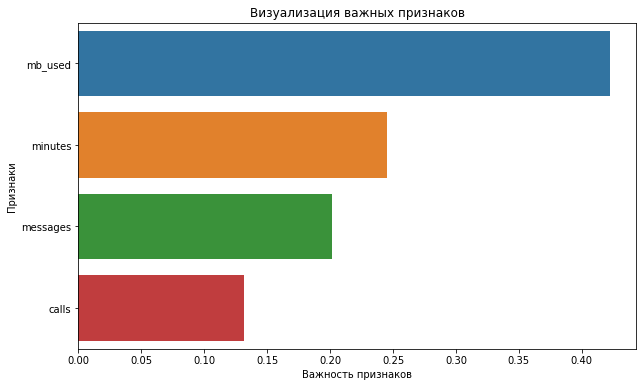

In [20]:
plt.figure(figsize=(10,6))

sns.barplot(x=fi['importance'], y=fi['feature'])

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

In [21]:
metrics(best_result_d, 'DT Classifier', compare_models)

,Accuracy_valid
Baseline model,0.706065
RF Classifier,0.810264
DT Classifier,0.785381


### Логистическая регрессия

In [22]:
%%time

#посмотрим на модель логистической регрессии

model_l = LogisticRegression(random_state=25) 
model_l.fit(features_train, target_train) 
result_l = model_l.score(features_valid, target_valid)

print("Accuracy модели логистической регрессии на валидационной выборке:", result_l)

Accuracy модели логистической регрессии на валидационной выборке: 0.7107309486780715
CPU times: user 32.3 ms, sys: 3 ms, total: 35.3 ms
Wall time: 43 ms


In [23]:
metrics(result_l, 'Logistic Regression', compare_models)

,Accuracy_valid
Baseline model,0.706065
RF Classifier,0.810264
DT Classifier,0.785381
Logistic Regression,0.710731


**Комментарий:**
<br> Мы обучили три модели - Случайный лес, Дерево решений и Логистическая регрессия. Самый низкий результат показала модель Логистической регрессии. Был проведен анализ важности признаков для моделей Случайного леса и Дерева решений, оба анализа показали, что параметр calls наименее важен для обеих моделей. Сделаем новую выборку уже без этого параметра и посмотрим на результаты.

### Повторное обучение

In [24]:
#создаем новые переменные

features_train_new = data_train.drop(['is_ultra', 'calls'], axis=1)

features_valid_new = data_valid.drop(['is_ultra', 'calls'], axis=1)

#features_test = data_test.drop(['is_ultra'], axis=1)

**Случайный лес**

In [25]:
%%time 

# подберем наилучшие параметры для модели случайного леса

best_features2 = 0
best_criterion2 = None
best_depth2 = 0
best_model_r_new = None
best_result_r2 = 0
best_est2 = 0

for crit in tqdm(['gini', 'entropy']):
    for max_features in ['sqrt', 'log2']:
        for est in range(7,35):
            for depth in range(5,25):
                model_r_new = RandomForestClassifier(random_state=45, criterion=crit,
                                    max_features=max_features, max_depth=depth, n_estimators=est)
                model_r_new.fit(features_train_new, target_train)
                predictions = model_r_new.predict(features_valid_new)
                result = model_r_new.score(features_valid_new, target_valid)
                if result > best_result_r2:
                    best_criterion2 = crit
                    best_features2 = max_features
                    best_depth2 = depth
                    best_model_r_new = model_r_new
                    best_result_r2 = result
                    best_est2 = est

print('Accuracy наилучшей модели на валидационной выборке:', best_result_r2)
print('Количество деревьев:', best_est2)
print('Глубина:', best_depth2)
print('Число признаков:', best_features2)
print('Критерий расщепления:', best_criterion2)

100%|██████████| 2/2 [03:03<00:00, 91.90s/it]

Accuracy наилучшей модели на валидационной выборке: 0.80248833592535
Количество деревьев: 18
Глубина: 13
Число признаков: sqrt
Критерий расщепления: entropy
CPU times: user 3min 3s, sys: 640 ms, total: 3min 3s
Wall time: 3min 3s


In [26]:
metrics(best_result_r2, 'RF Classifier without calls', compare_models)

,Accuracy_valid
Baseline model,0.706065
RF Classifier,0.810264
DT Classifier,0.785381
Logistic Regression,0.710731
RF Classifier without calls,0.802488


**Дерево решений**

In [27]:
%%time 

# подберем наилучшие параметры для модели дерева решений

best_features2 = 0
best_criterion2 = None
best_depth2 = 0
best_model_d_new = None
best_result_d2 = 0

for crit in tqdm(['gini', 'entropy']):
    for max_features in ['sqrt', 'log2']:
        for depth in range(5,25):
             model_d_new = DecisionTreeClassifier(random_state=4545, criterion=crit,
                                     max_depth=depth)
             model_d_new.fit(features_train_new, target_train)
             predictions = model_d_new.predict(features_valid_new)
             result = model_d_new.score(features_valid_new, target_valid)
             if result > best_result_d2:
                best_criterion2 = crit
                best_features2 = max_features
                best_depth2 = depth
                best_model_d_new = model_d_new
                best_result_d2 = result
                    

print('Accuracy наилучшей модели на валидационной выборке:', best_result_d2)
print('Глубина:', best_depth2)
print('Число признаков:', best_features2)
print('Критерий расщепления:', best_criterion2)

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
Глубина: 5
Число признаков: sqrt
Критерий расщепления: gini
CPU times: user 1.08 s, sys: 6.01 ms, total: 1.09 s
Wall time: 1.1 s


In [28]:
metrics(best_result_d2, 'DT Classifier without calls', compare_models)

,Accuracy_valid
Baseline model,0.706065
RF Classifier,0.810264
DT Classifier,0.785381
Logistic Regression,0.710731
RF Classifier without calls,0.802488
DT Classifier without calls,0.788491


**Комментарий:**
<br>После удаления параметра ***calls*** метрика у Случайного леса снизилась, а у Дерева решений очень незначительно увеличилась. Однако, это не привело нас к желаемому результату - повышению метрики.
<br> Таким образом, наилучший результат показала модель Случайного леса (с параметром ***calls***). Ее результат прошел проверку на адекватность. Посмотрим на результаты на тестовой выборке.

## Проверьте модель на тестовой выборке

In [29]:
predictions_final_r = best_model_r.predict(features_test)
result_rf = accuracy_score(target_test, predictions_final_r)
print('Accuracy модели на тестовой выборке:', result_rf)

Accuracy модели на тестовой выборке: 0.7978227060653188


**Общий вывод** 
<br>Наилучший результат показала модель случайного леса со следующими гиперпараметрами:
- Количество деревьев: 14
- Глубина: 9
- Число признаков: sqrt
- Критерий расщепления: entropy 

После проведения анализа важности параметров, было выявлено, что параметр calls влияет на обучение модели наименьшим образом. Однако, после его удаления из выборок, результат модели Случайного леса стал меньше. Результат Дерева решений немного улучшился, но практически незначительно.
<br>На тесте модель Случайного леса (со всеми фичами) показала результат гораздо ниже, хотя на валидационной выборке результат был довольно высоким: 0.81 (валидационная выборка) и 0.79 (тест). 
<br>Несмотря на это, условия задачи были выполнены, поэтому рекомендуемая модель для заказчика - Случайный лес.